In [419]:
import os
import sys

import numpy as np 
import pandas as pd 

from scipy import stats
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns

import matplotlib.pyplot as plt 
import nibabel as nib
import nilearn.plotting as plotting

In [183]:
# Create a dataset specific dictionary with each key correspond

def load_dataset(path_to_dataset, dataset_name): 
    morphometric_feature_dict = {} 
    for feature in ['CT', 'GM', 'SA', 'GC', 'MC',  'MD', 'FA']: 
        filepath = os.path.join(path_to_dataset, 'PARC500_' + feature + '.dat')
        morphometric_feature_dict[feature] = pd.read_csv(filepath,
                                                         header=None, delimiter=None)
    for feature in ['sex', 'group', 'age']: 
        filepath = os.path.join(path_to_dataset, feature + '.dat')
        morphometric_feature_dict[feature] = pd.read_csv(filepath,
                                                         header=None, delimiter=None)
    morphometric_feature_dict['dataset'] = dataset_name 
    return morphometric_feature_dict
    

In [431]:
def compute_morphometric_similarities(morphometric_feature_dict): 
    nregs=308; # number of regions    
    age = [x for x in morphometric_feature_dict['age'][0]]
    sex = [x for x in morphometric_feature_dict['sex'][0]]
    group = [x for x in morphometric_feature_dict['group'][0]]
    nsubs = len(age)
    dataset = morphometric_feature_dict['dataset']
    
    morphometric_features = ['CT', 'SA', 'GM', 'MC', 'GC', 'FA', 'MD']
    
    # Calculate the morphometric similarity matrices:
    # z-score each feature and construct a new dictionary
    
    zscored_dict = {}
    for feature in morphometric_features: 
        zscored_dict[feature] = stats.zscore(morphometric_feature_dict[feature].transpose())
    
    # Create a 3D array - sub x region x feature
    
    subj_features7 = np.zeros((nsubs,nregs,7))
    for i in range(0, nsubs): 
        for j in range(0, len(morphometric_features)): 
            mf = morphometric_features[j]
            subj_features7[i, :, j] = zscored_dict[mf][:,i]
    
    # Calculate the MS matrices by correlating all inputs and set the diagonal to zero:
    subj_MSN_7 = np.zeros((nsubs,nregs,nregs))
    for i in range(0, nsubs):
        subj_MSN_7[i, :, :] = np.corrcoef(subj_features7[i, :, :])
        for j in range(0, nregs): 
            subj_MSN_7[i, j, j] = 0
            
    # Compute average regional MSN + regional residuals
    meanMS_regional = np.zeros((nsubs, nregs))
    for i in range(0, nsubs):
        meanMS_regional[i, :] = subj_MSN_7[i].sum(axis=1)/(nregs-1)

    # create sub by regressors array - age, sex, age*sex
    X = np.zeros((nsubs, 4))
    X[:,0] = 1
    X[:,1] = age
    X[:,2] = sex
    X[:,3] = list(X[:,1] * X[:, 2])
    
    # fit lin reg and create region by subject residuals array
    # evaluate global differences in morphometric similarity
    myresid_region = np.zeros((nregs, nsubs))
    for i in range(0, nregs):
        y = list(meanMS_regional[:, i])
        reg = LinearRegression().fit(X,y)
        b = reg.coef_
        YFIT = b[0] + b[1]*X[:,1] + b[2]*X[:,2] + b[3]*X[:,3]
        myresid_region[i,:] = y-YFIT

    cons = [i for i,val in enumerate(group) if val==1]
    pats = [i for i,val in enumerate(group) if val==2]

    x = myresid_region[:, cons].reshape(nregs*len(cons),1)
    y = myresid_region[:, pats].reshape(nregs*len(pats),1)
    
    sns.distplot(x, bins=10, label="Controls", norm_hist=True, kde=False)
    sns.distplot(y, bins=10, label="Patients", norm_hist=True, kde=False)


    plt.xlim([-0.1, 0.1])
    plt.ylabel("Probability", fontsize=14)
    plt.xlabel('MS- regional residuals', fontsize=14)
    plt.legend()
    plt.title(dataset, fontsize=14)
    plt.show()
    plt.close() 
    
    meanMS = []
    for i in range(0, nsubs):
        meanMS.append(np.mean(meanMS_regional[i,:]))

    tbl = pd.DataFrame({'Age':age,
                    'Sex': sex, 
                    'Group': group, 
                    'MeanMS': meanMS})


    results = smf.ols('MeanMS ~ Age * C(Sex) + C(Group)', data=tbl).fit()
    p_val_group = results.pvalues[2]
    
    myresid_region_mean = [] 
    for i in range(0, nsubs):
        myresid_region_mean.append(np.mean(myresid_region[:, i]))
    tbl['myresid_region_mean'] = myresid_region_mean

        
    ax = sns.boxplot(x="Group", y="myresid_region_mean", data=tbl)
    ax.set_xticklabels(["Controls", "Patients"], fontsize=14)
    ax.set_xlabel("Group", fontsize=14)
    ax.set_ylabel("Mean Residual", fontsize=14)
    ax.set_title(dataset, fontsize=14)
    plt.show()
    plt.close()
    
    mytstat = [] 
    mypstat = []

    for i in range(0, nregs):
        tbl = pd.DataFrame({'Age':age,
                            'Sex': sex, 
                            'Group': group, 
                            'MeanMS_Regional': meanMS_regional[:,i]})
        results = smf.ols('MeanMS_Regional ~ Age * C(Sex) + C(Group)', data=tbl).fit()
        mytstat.append(results.tvalues[2])
        mypstat.append(results.pvalues[2])
    meanMS_regional_controls = meanMS_regional[cons,:]
    meanMS_regional_patients = meanMS_regional[pats,:]
    
    return mytstat, mypstat, meanMS_regional_controls, meanMS_regional_patients
    

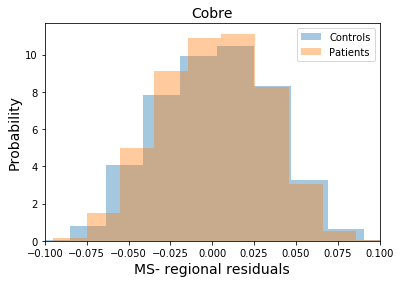

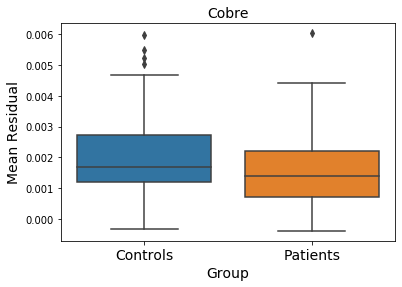

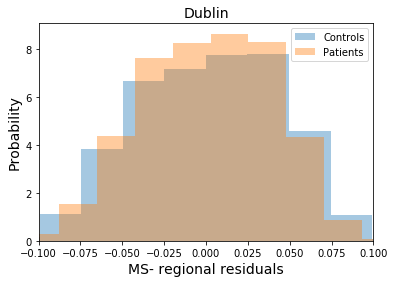

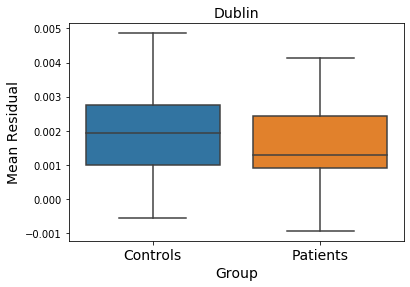

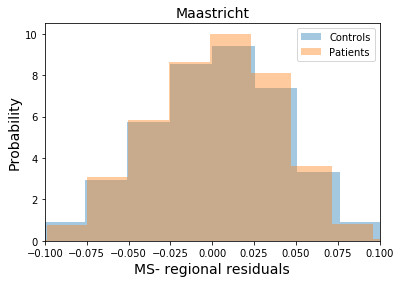

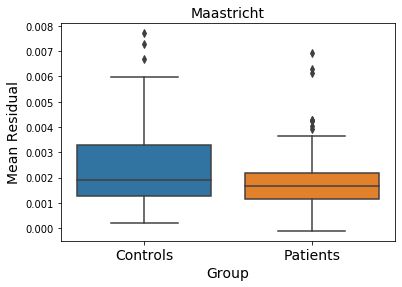

In [444]:
paths_to_datasets = ['Data_MS_SZ/Cobre/', 'Data_MS_SZ/Dublin/', 'Data_MS_SZ/Maastricht_GROUP/']
datasets = ['Cobre', 'Dublin', 'Maastricht']

tstat_dict = {} 
pstat_dict = {}
meanMS_regional_controls_dict = {}
meanMS_regional_patients_dict = {}
for i, path_to_dataset in enumerate(dataset_paths): 
    dataset_name = datasets[i]
    morphometric_feature_dict = load_dataset(path_to_dataset, dataset_name)
    tstat, pstat, meanMS_regional_controls, meanMS_regional_patients = compute_morphometric_similarities(morphometric_feature_dict) 
    tstat_dict[dataset_name] = tstat 
    pstat_dict[dataset_name] = pstat
    meanMS_regional_controls_dict[dataset_name] = meanMS_regional_controls
    meanMS_regional_patients_dict[dataset_name] = meanMS_regional_patients
    

In [466]:
meanMS_con = np.mean(np.concatenate(list(meanMS_regional_controls_dict.values())), axis=0)

In [467]:
meantstat = np.mean(list(tstat_dict.values()), axis=0)

Text(0.5, 1.0, 'Mean control MS vs case-control t-map')

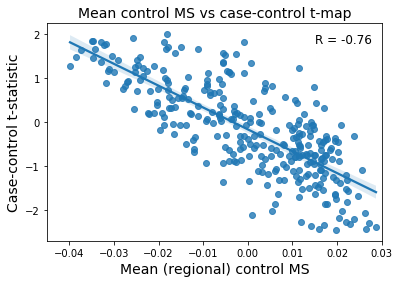

In [477]:
sns.regplot(meanMS_con, meantstat)
r,p = stats.pearsonr(meanMS_con, meantstat)
plt.xlim([-0.045, 0.03])
plt.xlabel("Mean (regional) control MS", fontsize=14)
plt.ylabel("Case-control t-statistic", fontsize=14)
plt.text(s="R = {0}".format(np.round(r,2)), x=0.015, y=1.8, fontsize=12)
plt.title("Mean control MS vs case-control t-map", fontsize=14)